<a href="https://colab.research.google.com/github/gabrielagcam/Detec-o-precoce-de-AVCs/blob/main/stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Carregando os dados

In [ ]:
pip install tensorflow_decision_forests

In [ ]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Biblioteca para balanceamento de classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [ ]:
# Carregando o dataset
df = pd.read_csv('full_data.csv')

# Visualizando as primeiras linhas
df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:
# Verificando formato (linhas e colunas)
print("Dimensões do dataframe:", df.shape)

# Exibindo informações gerais (tipo de dado, colunas, valores não-nulos)
df.info()

Dimensões do dataframe: (4981, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


# 2. Análise exploratória

In [ ]:
# Descrição estatística dos dados
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [ ]:
# Verificando a quantidade de NaN
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


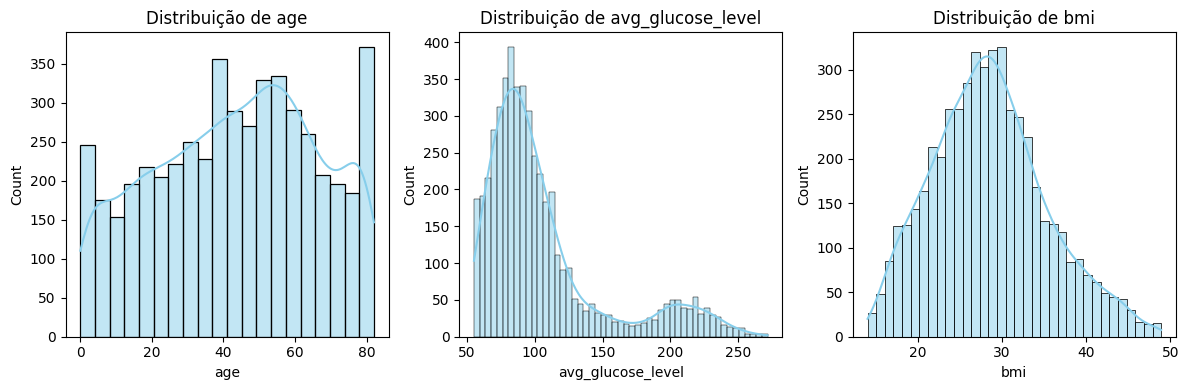

In [ ]:
# Distribuição de frequência de algumas variáveis
num_cols = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f"Distribuição de {col}")
plt.tight_layout()
plt.show()

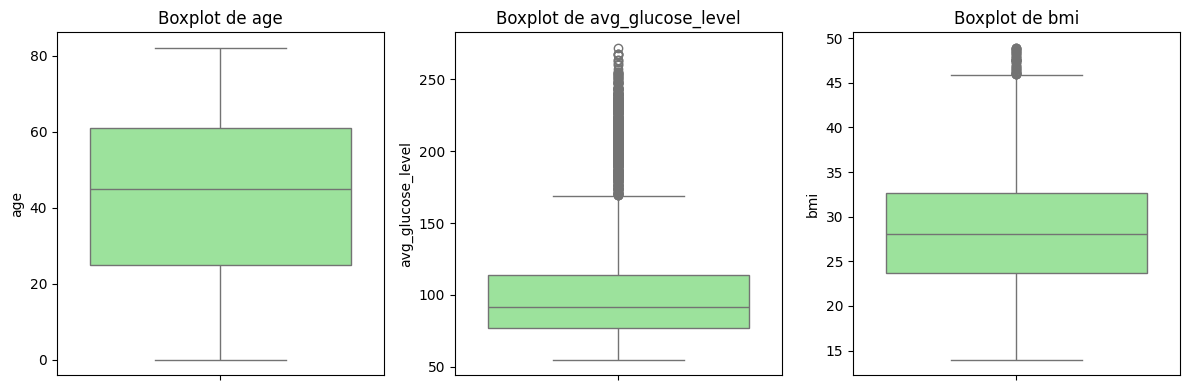

In [ ]:
# Análise de Outliers
plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

<ipython-input-9-4873b96c1261>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')
<ipython-input-9-4873b96c1261>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')
<ipython-input-9-4873b96c1261>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')
<ipython-input-9-4873b96c1261>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sa

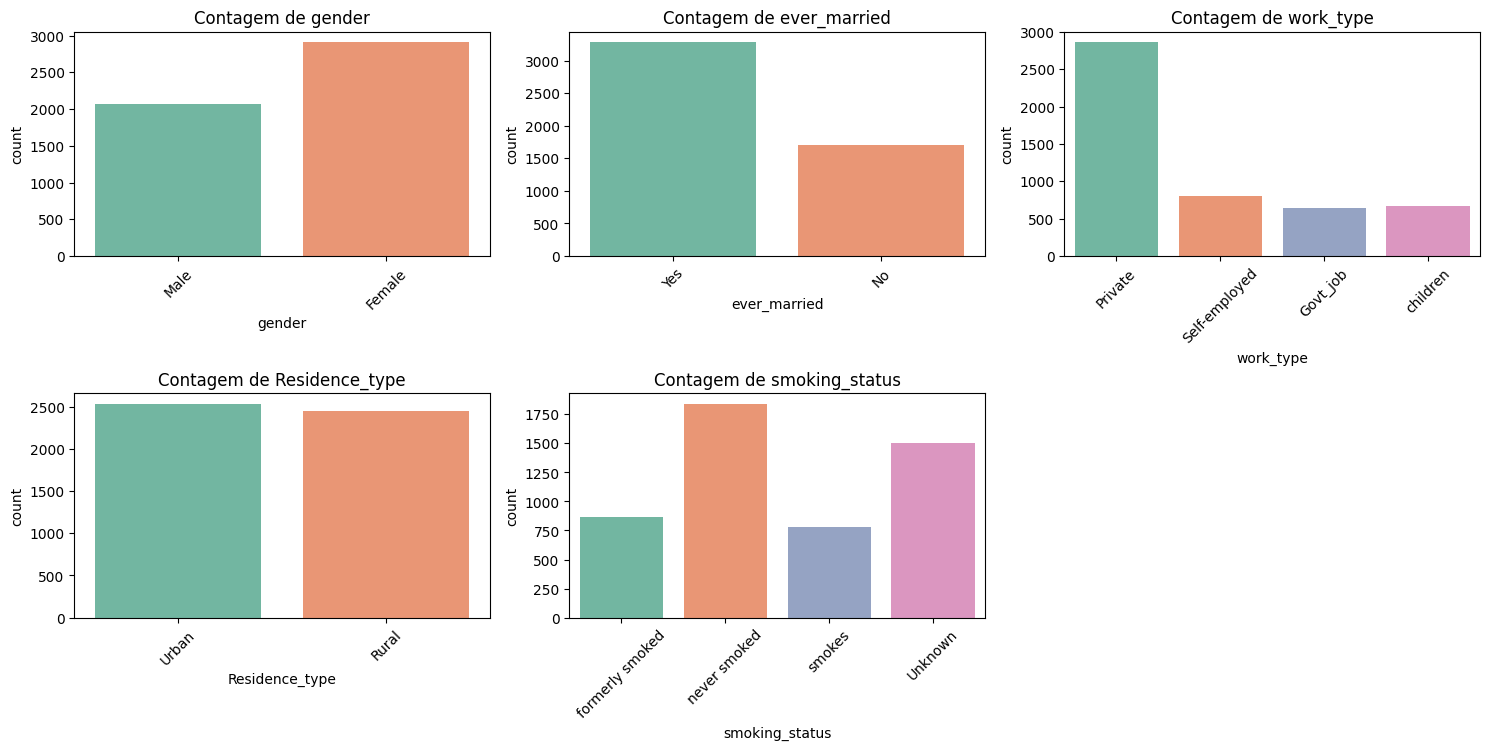

In [ ]:
# Análise de desbalanceamento de classes
cat_cols = ['gender', 'ever_married','work_type', 'Residence_type', 'smoking_status']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f"Contagem de {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

<ipython-input-10-0619b9de6a02>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')
<ipython-input-10-0619b9de6a02>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')
<ipython-input-10-0619b9de6a02>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2')


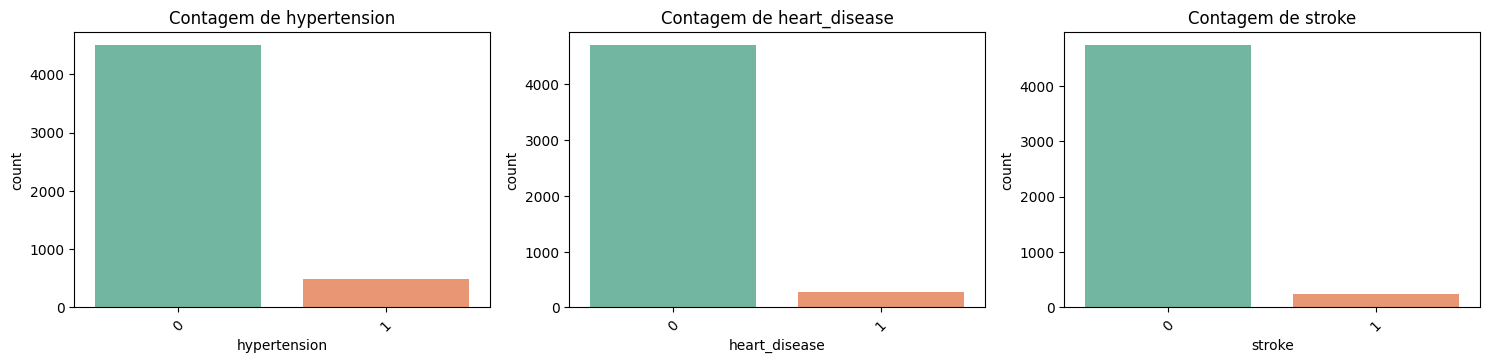

In [ ]:
# Análise de desbalanceamento de classes
num_cols = [ 'hypertension','heart_disease', 'stroke']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f"Contagem de {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

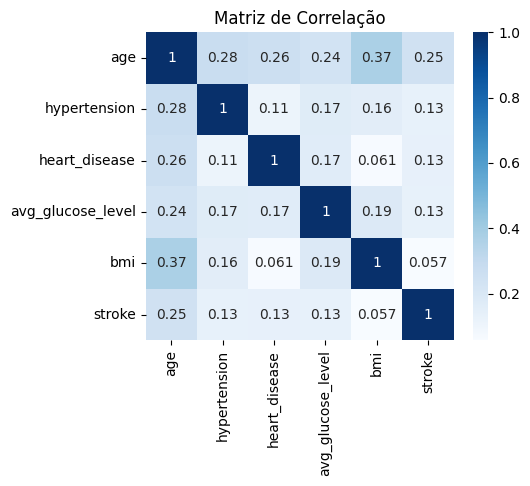

In [ ]:
# Analisando correlação entre as variáveis
corr = df[['age','hypertension','heart_disease','avg_glucose_level','bmi','stroke']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='Blues', square=True)
plt.title("Matriz de Correlação")
plt.show()

# 3. One-Hot-Encoding das variáveis categóricas

In [ ]:
cat_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
df = pd.get_dummies(df, columns=[col for col in df.columns if col in cat_cols]).astype(int)


# 4. Desbalanceamento de classes:
# Solução: Oversampling + Undersampling (ao mesmo tempo)
## - Oversampling (sobreamostragem) → Aumenta a quantidade de amostras da classe minoritária.
## - Undersampling (subamostragem) → Reduz a quantidade de amostras da classe majoritária.

In [ ]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228,36,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80,0,1,105,32,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49,0,0,171,34,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79,1,0,174,24,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81,0,0,186,29,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0


In [ ]:
# Removendo a coluna 'id' (não relevante para o modelo)
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

In [ ]:
# Separação de variáveis preditoras (X) e alvo (y)
X = df.drop('stroke', axis=1)  # Todas as colunas menos 'stroke'
y = df['stroke']               # Coluna alvo

In [ ]:
y.value_counts()

,count
stroke,
0,4733
1,248


<Axes: ylabel='count'>

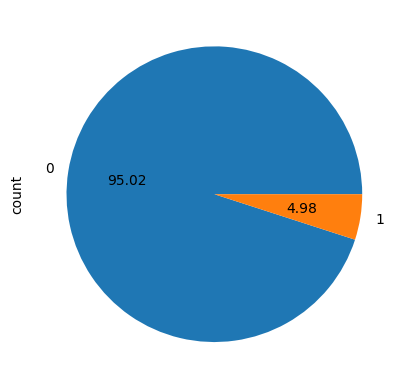

In [ ]:
y.value_counts().plot.pie(autopct='%.2f')

In [ ]:
# Aplicando o pipeline de balanceamento antes do split
under = RandomUnderSampler()  # Reduz classe majoritária
over = RandomOverSampler()    # Aumenta classe minoritária

pipeline = Pipeline(steps=[('o', over), ('u', under)])  # Primeiro Over, depois Under

# Aplicando o balanceamento no dataset completo antes do split
X, y = pipeline.fit_resample(X, y)

<Axes: ylabel='count'>

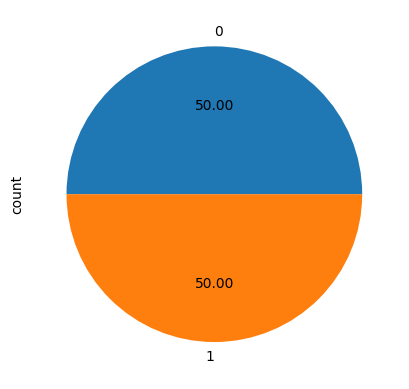

In [ ]:
y.value_counts().plot.pie(autopct='%.2f')

In [ ]:
y.value_counts()

,count
stroke,
0,4733
1,4733


# Encoding das variáveis categóricas

In [ ]:
# Divisão em treino e teste após balanceamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Criando DataFrames para conversão em Dataset TensorFlow
train_df = X_train.copy()
train_df['stroke'] = y_train  # Adicionando novamente a coluna alvo

test_df = X_test.copy()
test_df['stroke'] = y_test

In [ ]:
# Convertendo para `tf.data.Dataset`
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="stroke")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="stroke")

#5. Random Forest

In [ ]:
# Criando e treinando o modelo Random Forest
random_forest = tfdf.keras.RandomForestModel(
    num_trees=100,    # Número de árvores na floresta
    max_depth=None,   # Profundidade máxima (None = sem limite)
    random_seed=42,   # Para reprodutibilidade
)

random_forest.fit(train_ds)  # Treinando o modelo

Use /tmp/tmpn7p5ipfc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:12.470925. Found 7572 examples.
Training model...
Model trained in 0:00:03.390598
Compiling model...
Model compiled.


In [ ]:
# Avaliação do modelo
evaluation = random_forest.evaluate(test_ds, return_dict=True)
print(f"Avaliação do modelo no Test set: {evaluation}")

2/2 [==============================] - 1s 81ms/step - loss: 0.0000e+00
Avaliação do modelo no Test set: {'loss': 0.0}


In [ ]:
# Realizando as predições
y_pred_proba = random_forest.predict(test_ds)

# Shape da prediç~]ao
print("Shape das predições:", y_pred_proba.shape)

# Converta as probabilidades em classes
y_pred_classes = (y_pred_proba > 0.5).astype(int).reshape(-1)

# Avalie o modelo
print("\n Relatório de Classificação:\n", classification_report(y_test, y_pred_classes))
print("\n Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_classes))

2/2 [==============================] - 0s 73ms/step
Shape das predições: (1894, 1)

 Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       951
           1       0.93      1.00      0.96       943

    accuracy                           0.96      1894
   macro avg       0.97      0.96      0.96      1894
weighted avg       0.97      0.96      0.96      1894


 Matriz de Confusão:
 [[882  69]
 [  0 943]]
